In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import LabelEncoder

#### Read data

In [2]:
ks = pd.read_csv('../datasets/ks-projects-201801.csv', parse_dates=['deadline', 'launched'])
ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
# let's drop all live projects
ks = ks.query('state != "live"')

### Target Column
Add outcome columns, "successful" == 1, all others == 0

In [4]:
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

### Timestamp features

In [5]:
ks = ks.assign(hour=ks.launched.dt.hour,
              day=ks.launched.dt.day,
              month=ks.launched.dt.month,
              year=ks.launched.dt.year)
ks.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,outcome,hour,day,month,year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0,12,11,8,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0,4,2,9,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0,0,12,1,2013


### Label Encoding

In [6]:
cat_features = ['category', 'currency', 'country']

encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)
baseline_data.head()

,goal,hour,day,month,year,outcome,category,currency,country
0,1000.0,12,11,8,2015,0,108,5,9
1,30000.0,4,2,9,2017,0,93,13,22
2,45000.0,0,12,1,2013,0,93,13,22
3,5000.0,3,17,3,2012,0,90,13,22
4,19500.0,8,4,7,2015,0,55,13,22


### Build Interactions

In [7]:
interactions = ks['category'] + "_" + ks['country']
interactions.head()

0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
dtype: object

### Label encode interactions

In [8]:
label_enc = LabelEncoder()
data_interaction = baseline_data.assign(category_country=label_enc.fit_transform(interactions))
data_interaction.head()

,goal,hour,day,month,year,outcome,category,currency,country,category_country
0,1000.0,12,11,8,2015,0,108,5,9,1900
1,30000.0,4,2,9,2017,0,93,13,22,1630
2,45000.0,0,12,1,2013,0,93,13,22,1630
3,5000.0,3,17,3,2012,0,90,13,22,1595
4,19500.0,8,4,7,2015,0,55,13,22,979


### Number of projects last week

In [9]:
launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
launched.head(10)

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
Name: count_7_days, dtype: int64

In [10]:
%%time
count_7_days = launched.rolling('7d').count() - 1
count_7_days.head(10)

CPU times: user 25.2 ms, sys: 3.25 ms, total: 28.4 ms
Wall time: 24.2 ms


launched
1970-01-01 01:00:00    0.0
1970-01-01 01:00:00    1.0
1970-01-01 01:00:00    2.0
1970-01-01 01:00:00    3.0
1970-01-01 01:00:00    4.0
1970-01-01 01:00:00    5.0
1970-01-01 01:00:00    6.0
2009-04-21 21:02:48    0.0
2009-04-23 00:07:53    1.0
2009-04-24 21:52:03    2.0
Name: count_7_days, dtype: float64

Text(0.5, 1.0, 'Competitions in the last 7 days')

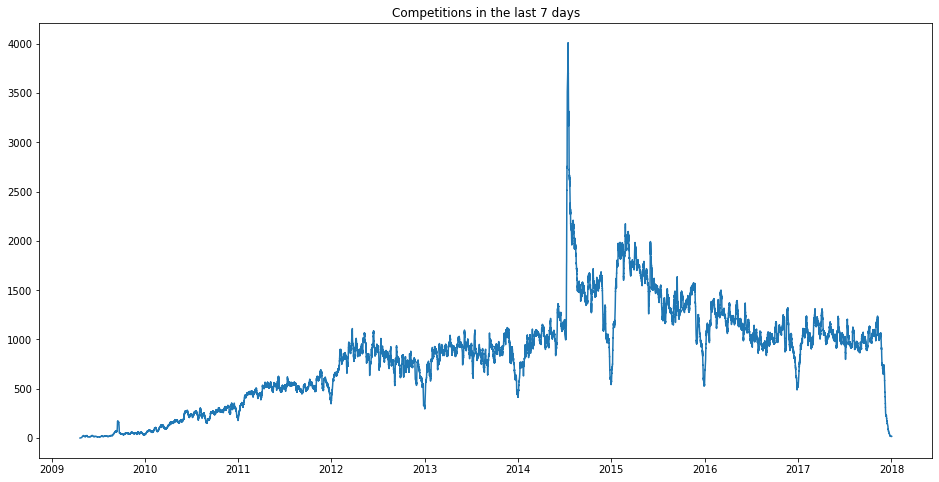

In [11]:
# ignore records with broken launch dates
plt.figure(figsize=(16, 8))
plt.plot(count_7_days[7:])
plt.title("Competitions in the last 7 days")


In [12]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)
count_7_days.head()

0    1409.0
1     957.0
2     739.0
3     907.0
4    1429.0
Name: count_7_days, dtype: float64

In [13]:
baseline_data.join(count_7_days).head(10)

,goal,hour,day,month,year,outcome,category,currency,country,count_7_days
0,1000.0,12,11,8,2015,0,108,5,9,1409.0
1,30000.0,4,2,9,2017,0,93,13,22,957.0
2,45000.0,0,12,1,2013,0,93,13,22,739.0
3,5000.0,3,17,3,2012,0,90,13,22,907.0
4,19500.0,8,4,7,2015,0,55,13,22,1429.0
5,50000.0,13,26,2,2016,1,123,13,22,1284.0
6,1000.0,18,1,12,2014,1,58,13,22,1119.0
7,25000.0,20,1,2,2016,0,41,13,22,1391.0
8,125000.0,18,24,4,2014,0,113,13,22,1043.0
9,65000.0,21,11,7,2014,0,39,13,22,3199.0


So we have a new column count_7_days appended to our `baseline_data`

In [15]:
def time_since_last_project(series):
    return series.diff().dt.total_seconds() / 3600

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head()

,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN


Let's fill the missing values and reset the index

In [25]:
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(baseline_data.index)
timedeltas.head()

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389


### Transforming numerical features

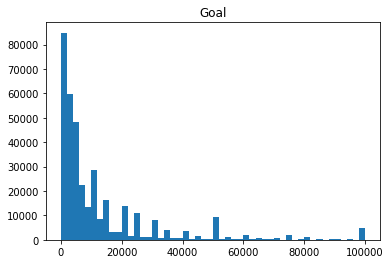

In [37]:
plt.hist(ks.goal, range=(0, 100000), bins=50);
plt.title('Goal');

### SQRT 


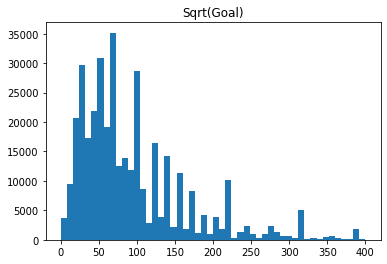

In [41]:
plt.hist(np.sqrt(ks.goal), range=(0, 400), bins=50);
plt.title('Sqrt(Goal)');

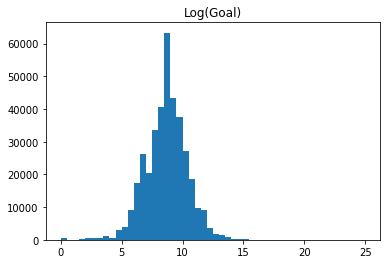

In [51]:
plt.hist(np.log(ks.goal), range=(0,25), bins=50);
plt.title('Log(Goal)');